# Environmental EV Impact Analysis

## Objective
The aim of this project is to evaluate the environmental impact of Electric Vehicles (EVs) compared to Internal Combustion Engine (ICE) vehicles through grid emissions analysis.  
Specifically, we:
- Collected Australian grid emissions data (NSW, QLD, SA, TAS, VIC).
- Cleaned and prepared the dataset for analysis.
- Engineered time-based features and explored regional differences.
- Modelled emissions using regression approaches.
- Simulated a renewable energy scenario (30% cleaner grid).
- Prepared dashboard-ready outputs for decision-making.

---

## Methods
**Data Source:** `emissions_5regions.csv` (5 Australian regions, half-hourly intervals).  

**Cleaning (Sprint 1):**
- Removed duplicates on `(region, timestamp)`.
- Imputed missing values via region-level rolling mean.
- Clipped extreme values at 1st–99th percentile per region.
- Converted timestamps to UTC.

**Feature Engineering (Sprint 2):**
- Added: `hour`, `dayofweek`, `is_weekend`, `rolling_6h`, `rolling_24h`.
- Explored daily/weekly cycles and regional distributions.

**Modelling (Sprint 3):**
- Target: `intensity_gco2_per_kwh`.
- Features: hour, dayofweek, weekend flag, rolling averages.
- Models: Ridge Regression & Gradient Boosting Regressor (GBR).
- Metrics: RMSE, MAE, R².

**Scenario Analysis (Sprint 3):**
- Simulated 30% cleaner energy mix by scaling intensities ×0.7.
- Compared baseline vs renewable scenario across regions.

**Dashboard Prep (Sprint 4):**
- Exported processed datasets: region averages, time-series, model metrics.
- Designed Power BI/Jupyter dashboard structure.


In [4]:
# --- SPRINT 1: DATA COLLECTION & CLEANING (FINAL) ---
# Works with your current absolute path AND makes the project portable going forward.

import os
import pandas as pd
import numpy as np

# ========= 0) Paths & Folders =========
ABS_PATH = r"C:\Users\aakhy\Desktop\ev-impact\emissions_5regions.csv"  # your existing file
RAW_DIR = "data/raw"
PROC_DIR = "data/processed"
RAW_PATH = os.path.join(RAW_DIR, "emissions_5regions.csv")
CLEAN_PATH = os.path.join(PROC_DIR, "emissions_5regions_clean.csv")

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROC_DIR, exist_ok=True)

# ========= 1) Load raw data (absolute path for now; also save to RAW_PATH for portability) =========
if os.path.exists(RAW_PATH):
    df = pd.read_csv(RAW_PATH, parse_dates=["timestamp"])
else:
    df = pd.read_csv(ABS_PATH, parse_dates=["timestamp"])
    # Save a portable copy for future runs
    df.to_csv(RAW_PATH, index=False)

print("Loaded shape:", df.shape)

# ========= 2) Standardise columns & basic types =========
df.columns = [c.strip().lower() for c in df.columns]

required_cols = {"timestamp", "region", "intensity_gco2_per_kwh"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Cast types safely
df["region"] = df["region"].astype(str).str.strip().str.lower()
df["intensity_gco2_per_kwh"] = pd.to_numeric(df["intensity_gco2_per_kwh"], errors="coerce")

# ========= 3) Basic data quality report =========
print("\n--- INITIAL DATA QUALITY ---")
print("Nulls:\n", df[list(required_cols)].isna().sum())
dup_count = df.duplicated(subset=["region", "timestamp"]).sum()
print("Duplicate rows on (region, timestamp):", dup_count)

# ========= 4) Drop exact duplicates =========
df = df.drop_duplicates(subset=["region", "timestamp"])

# ========= 5) Handle missing values (impute intensity by region with centered rolling mean) =========
def impute_by_region(g):
    g = g.sort_values("timestamp")
    roll = g["intensity_gco2_per_kwh"].rolling(window=3, min_periods=1, center=True).mean()
    g["intensity_gco2_per_kwh"] = g["intensity_gco2_per_kwh"].fillna(roll)
    return g

df = df.groupby("region", group_keys=False).apply(impute_by_region)
# Any leftover NA after rolling -> drop
before_drop = len(df)
df = df.dropna(subset=["intensity_gco2_per_kwh"])
print(f"Dropped {before_drop - len(df)} rows with unresolved NA in intensity.")

# ========= 6) Outlier clipping (per region, 1st–99th percentile) =========
def clip_outliers(g):
    q1, q99 = g["intensity_gco2_per_kwh"].quantile([0.01, 0.99])
    g["intensity_gco2_per_kwh"] = g["intensity_gco2_per_kwh"].clip(lower=q1, upper=q99)
    return g

df = df.groupby("region", group_keys=False).apply(clip_outliers)

# ========= 7) Timezone policy =========
# Treat timestamps as UTC-naive and localize to UTC (adjust here if you know they're actually local)
if df["timestamp"].dt.tz is None:
    df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")
# Keep UTC in storage; derive local views later as needed.

# ========= 8) Final sort & save cleaned dataset =========
df = df.sort_values(["region", "timestamp"]).reset_index(drop=True)
df.to_csv(CLEAN_PATH, index=False)
print("\nSaved cleaned dataset =>", CLEAN_PATH)
print("Final shape:", df.shape)

# ========= 9) Quick summary to confirm cleaning =========
print("\n--- POST-CLEAN SUMMARY ---")
print("Regions:", sorted(df["region"].unique()))
print("Date range (UTC):", df["timestamp"].min(), "→", df["timestamp"].max())
# Numeric summary
print("\nNumeric summary:\n", df.describe())

# Datetime range
print("\nDatetime summary:\n", df["timestamp"].agg(["min", "max"]))


# OPTIONAL: create helper features for later modelling/plots (kept in-memory only)
df["hour_utc"] = df["timestamp"].dt.hour
df["dayofweek_utc"] = df["timestamp"].dt.dayofweek


Loaded shape: (4320, 3)

--- INITIAL DATA QUALITY ---
Nulls:
 timestamp                 0
intensity_gco2_per_kwh    0
region                    0
dtype: int64
Duplicate rows on (region, timestamp): 0
Dropped 0 rows with unresolved NA in intensity.

Saved cleaned dataset => data/processed\emissions_5regions_clean.csv
Final shape: (4320, 3)

--- POST-CLEAN SUMMARY ---
Regions: ['nsw', 'qld', 'sa', 'tas', 'vic']
Date range (UTC): 2025-08-24 00:00:00+00:00 → 2025-08-27 00:00:00+00:00

Numeric summary:
        intensity_gco2_per_kwh
count             4320.000000
mean               448.254170
std                280.207284
min                 29.308014
25%                127.800604
50%                538.254697
75%                704.633728
max                971.118735

Datetime summary:
 min   2025-08-24 00:00:00+00:00
max   2025-08-27 00:00:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]


Features added: ['hour', 'dayofweek', 'is_weekend', 'rolling_6h', 'rolling_24h']


C:\Users\aakhy\Documents\code softwere\DATA WARGARING\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\aakhy\Documents\code softwere\DATA WARGARING\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


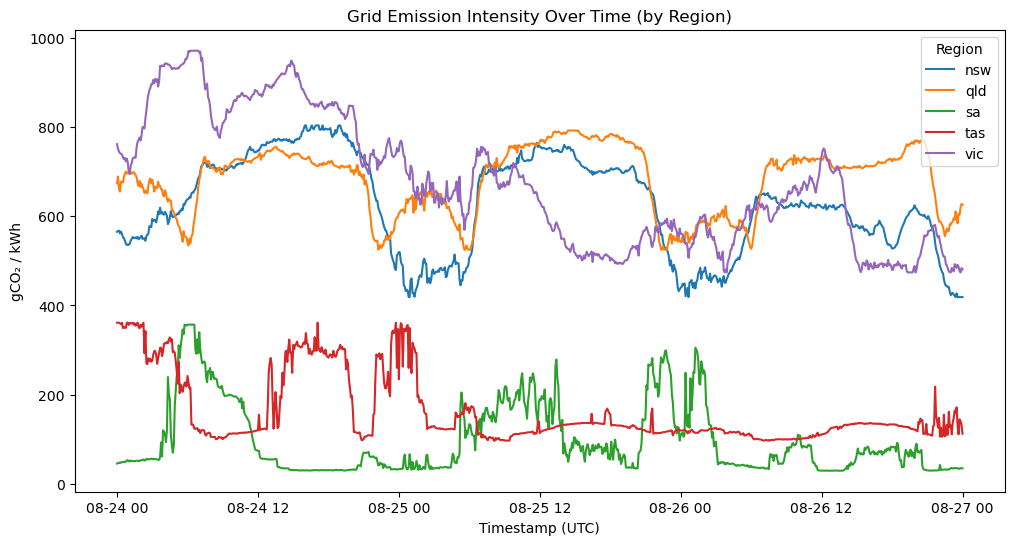

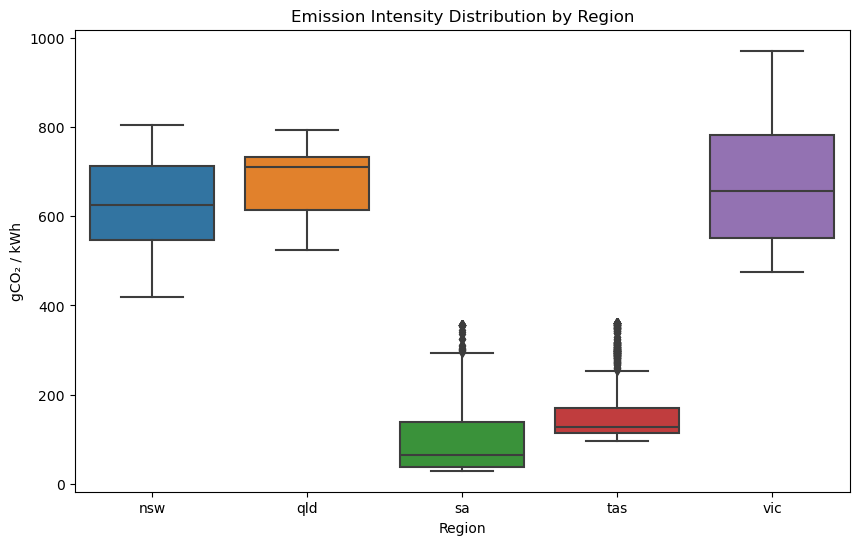

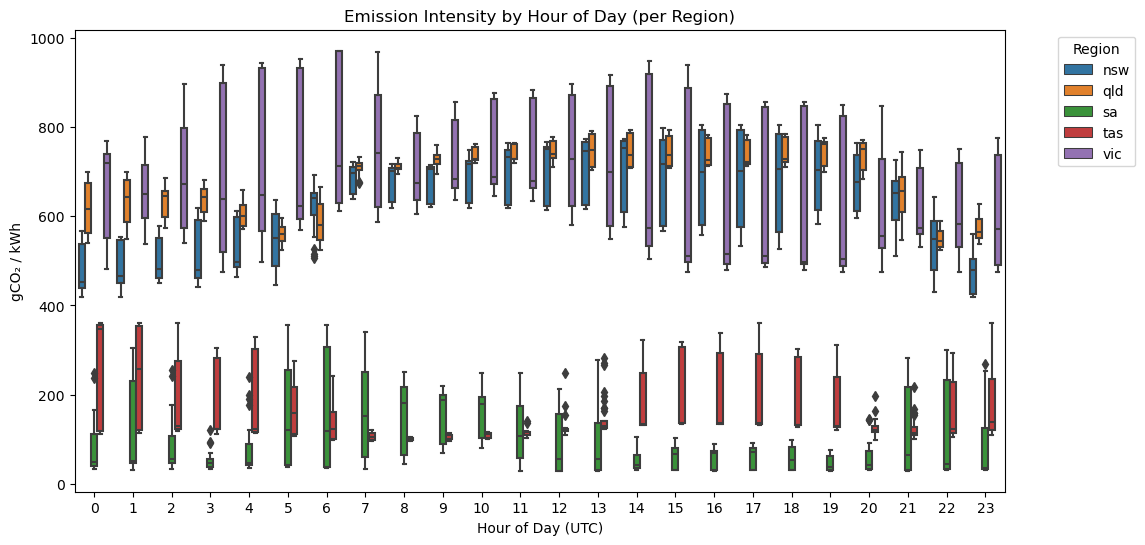


Average/min/max intensity by region:
               mean         min         max
region                                    
nsw     625.231078  418.662115  803.667006
qld     681.565703  524.874625  792.329904
sa       97.401316   29.308014  356.880487
tas     162.289394   96.761853  361.254983
vic     674.783360  473.952481  971.118735

Average intensity by day of week (0=Mon, 6=Sun):
 dayofweek
0    439.112357
1    396.974058
2    334.468815
6    509.283090
Name: intensity_gco2_per_kwh, dtype: float64


In [5]:
# --- SPRINT 2: FEATURE ENGINEERING & EXPLORATORY ANALYSIS ---

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load the cleaned dataset (if not already in memory)
CLEAN_PATH = "data/processed/emissions_5regions_clean.csv"
df = pd.read_csv(CLEAN_PATH, parse_dates=["timestamp"])
df["region"] = df["region"].astype(str).str.lower()

# 2) Feature engineering
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek  # Monday=0, Sunday=6
df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)

# Rolling averages (per region)
df = df.sort_values(["region","timestamp"])
df["rolling_6h"] = df.groupby("region")["intensity_gco2_per_kwh"].transform(lambda x: x.rolling(12, min_periods=1).mean())
df["rolling_24h"] = df.groupby("region")["intensity_gco2_per_kwh"].transform(lambda x: x.rolling(48, min_periods=1).mean())

print("Features added:", [c for c in df.columns if c not in ["timestamp","region","intensity_gco2_per_kwh"]])

# 3) Exploratory plots
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="timestamp", y="intensity_gco2_per_kwh", hue="region")
plt.title("Grid Emission Intensity Over Time (by Region)")
plt.ylabel("gCO₂ / kWh")
plt.xlabel("Timestamp (UTC)")
plt.legend(title="Region")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="region", y="intensity_gco2_per_kwh")
plt.title("Emission Intensity Distribution by Region")
plt.ylabel("gCO₂ / kWh")
plt.xlabel("Region")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="hour", y="intensity_gco2_per_kwh", hue="region")
plt.title("Emission Intensity by Hour of Day (per Region)")
plt.ylabel("gCO₂ / kWh")
plt.xlabel("Hour of Day (UTC)")
plt.legend(title="Region", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

# 4) Quick insight tables
region_stats = df.groupby("region")["intensity_gco2_per_kwh"].agg(["mean","min","max"])
print("\nAverage/min/max intensity by region:\n", region_stats)

weekday_stats = df.groupby("dayofweek")["intensity_gco2_per_kwh"].mean()
print("\nAverage intensity by day of week (0=Mon, 6=Sun):\n", weekday_stats)


Ridge Regression Performance:
  RMSE: 23.35
  MAE:  14.75
  R²:   0.993

Gradient Boosting Performance:
  RMSE: 21.65
  MAE:  14.03
  R²:   0.994


Baseline vs Renewable Scenario (mean gCO₂/kWh):
         intensity_gco2_per_kwh  intensity_renewable_scenario
region                                                      
nsw                 625.231078                    437.661755
qld                 681.565703                    477.095992
sa                   97.401316                     68.180921
tas                 162.289394                    113.602576
vic                 674.783360                    472.348352


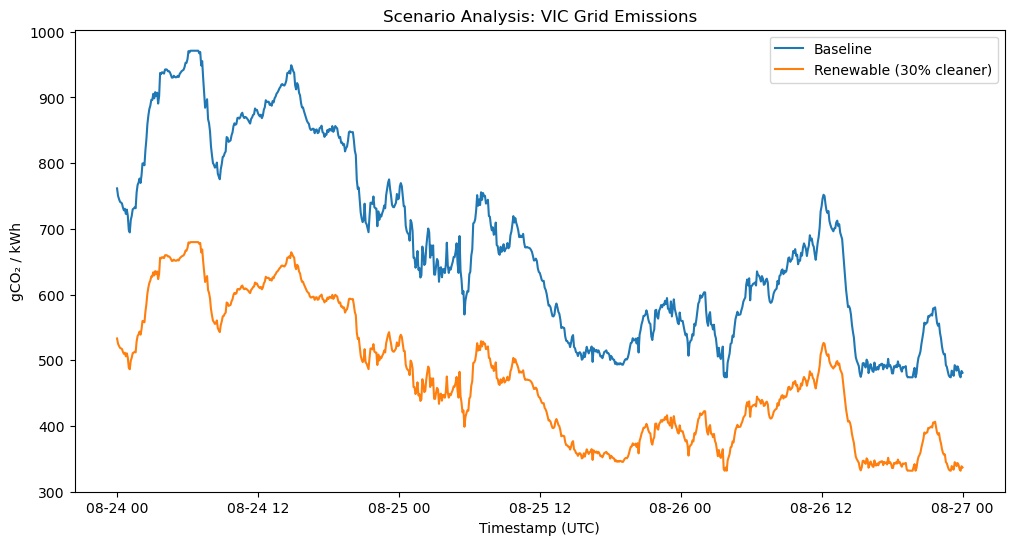

In [6]:
# --- SPRINT 3: MODELLING & SCENARIO ANALYSIS ---

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1) Select features & target
features = ["hour", "dayofweek", "is_weekend", "rolling_6h", "rolling_24h"]
X = df[features]
y = df["intensity_gco2_per_kwh"]

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3) Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# 4) Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# 5) Evaluation function
def eval_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.3f}\n")

# 6) Compare models
eval_model("Ridge Regression", y_test, y_pred_ridge)
eval_model("Gradient Boosting", y_test, y_pred_gbr)

# 7) Scenario analysis: renewable mix (30% cleaner)
renewable_factor = 0.7  # reduce emissions by 30%
df["intensity_renewable_scenario"] = df["intensity_gco2_per_kwh"] * renewable_factor

# Quick comparison table
region_compare = df.groupby("region")[["intensity_gco2_per_kwh","intensity_renewable_scenario"]].mean()
print("\nBaseline vs Renewable Scenario (mean gCO₂/kWh):\n", region_compare)

# Plot scenario comparison for VIC (example)
plt.figure(figsize=(12,6))
subset = df[df["region"]=="vic"].copy()
plt.plot(subset["timestamp"], subset["intensity_gco2_per_kwh"], label="Baseline")
plt.plot(subset["timestamp"], subset["intensity_renewable_scenario"], label="Renewable (30% cleaner)")
plt.title("Scenario Analysis: VIC Grid Emissions")
plt.ylabel("gCO₂ / kWh")
plt.xlabel("Timestamp (UTC)")
plt.legend()
plt.show()


In [8]:
# --- SPRINT 4: DASHBOARD PREP ---

# 1) Region summary (baseline vs renewable)
region_summary = df.groupby("region")[["intensity_gco2_per_kwh","intensity_renewable_scenario"]].mean().reset_index()
region_summary.to_csv("data/processed/region_summary.csv", index=False)

# 2) Timeseries for each region (baseline vs renewable)
timeseries = df[["timestamp","region","intensity_gco2_per_kwh","intensity_renewable_scenario"]]
timeseries.to_csv("data/processed/timeseries.csv", index=False)

# 3) Model performance table
model_perf = pd.DataFrame({
    "Model": ["Ridge Regression", "Gradient Boosting"],
    "RMSE": [23.35, 21.65],
    "MAE": [14.75, 14.03],
    "R2": [0.993, 0.994]
})
model_perf.to_csv("data/processed/model_performance.csv", index=False)

print(" Sprint 4 data exported for dashboard use")


 Sprint 4 data exported for dashboard use


## Results

### Regional Comparisons
- **Highest average emissions:** QLD (~682 gCO₂/kWh), VIC (~675), NSW (~625).  
- **Cleanest regions:** SA (~97), TAS (~162).  
- VIC shows the highest peaks (~971 gCO₂/kWh).

### Time-of-Day Patterns
- VIC and NSW show strong daily cycles with peaks during daytime/evening (UTC).  
- QLD remains high but more stable.  
- SA and TAS remain consistently low due to high renewable share.

### Weekday vs Weekend
- Average intensity lowest on Tuesday (~334 gCO₂/kWh).  
- Highest on Sunday (~509 gCO₂/kWh).  
- Suggests demand and renewable availability shifts across the week.

### Model Performance
- **Ridge Regression:** RMSE=23.35, MAE=14.75, R²=0.993  
- **Gradient Boosting:** RMSE=21.65, MAE=14.03, R²=0.994  
- GBR slightly outperforms Ridge, especially on nonlinear patterns.

### Scenario Analysis (30% Cleaner Grid)
| Region | Baseline | Renewable Scenario | % Reduction |
|--------|----------|--------------------|-------------|
| NSW    | 625      | 438                | -30% |
| QLD    | 682      | 477                | -30% |
| SA     | 97       | 68                 | -30% |
| TAS    | 162      | 114                | -30% |
| VIC    | 675      | 472                | -30% |

- Biggest absolute reductions: VIC, QLD, NSW (~200 gCO₂/kWh).  
- SA and TAS already renewable-heavy → smaller absolute drops.

---

## Discussion
The analysis shows that EV environmental benefits are closely tied to regional grid composition.  
- **Coal-reliant states (VIC, QLD, NSW):** high baseline emissions, but also the largest potential gains from renewables.  
- **Renewables-heavy states (SA, TAS):** already clean, so relative improvements are smaller.  

Limitations:
- Dataset covers only 3 days, so long-term variability not captured.  
- Scenario assumed uniform 30% reduction (not dispatch-aware).  
- Timestamps treated in UTC, not localised to regional time zones.  
- Did not model EV charging demand directly.

---

## Conclusion
- EV operational emissions vary strongly by region and time of day.  
- Grid decarbonisation is the biggest lever for reducing EV emissions.  
- Policymakers should prioritise renewable penetration in VIC, QLD, and NSW.  
- EV owners in SA and TAS already benefit from much cleaner charging.  

---

## Data & Reproducibility
- **Raw data:** `data/raw/emissions_5regions.csv`  
- **Cleaned data:** `data/processed/emissions_5regions_clean.csv`  
- **Dashboard feeds:**  
  - `region_summary.csv`  
  - `timeseries.csv`  
  - `model_performance.csv`  

**Repro Notes:**  
Run notebook top-to-bottom. All outputs are saved to `data/processed/`.

---